# Tutorial on Parallelized Calculations

Perform calculations for various observables, such as estimated exciton lifetimes, average charge separation, and dipole moments. This tutorial also demonstrates the use of `qDNA`'s parallelization capabilities.

* Exciton lifetime (in femtoseconds)
* Average charge separation between electron and hole (in Angstrom)
* Dipole moment (in Debye)
* Average exciton population on upper and lower DNA strands
  
As an example, the calculations are applied to all 64 possible DNA trimer/ triplet sequences.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dehe1011/QuantumDNA-notebooks/blob/main/tutorials/5_Evaluation.ipynb)

In [1]:
%load_ext autoreload
%autoreload 2

# Flags
save = False          # Set to True to enable saving results (currently unused in this script)
verbose = True        # Set to True to enable detailed logging

## Setup

In [2]:
import os
import importlib.util

# Check if the 'qDNA' package is already installed
qDNA_installed = importlib.util.find_spec('qDNA') is not None

if qDNA_installed:
    if verbose:
        print("Package 'qDNA' is already installed.")
        # Optional: Uncomment the next line to display qDNA package information
        # %pip show qDNA
else:
    # Install 'qDNA' package if not installed
    %pip install qDNA
    if verbose:
        print("Successfully installed the 'qDNA' package.")

Package 'qDNA' is already installed.


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

from qDNA import ROOT_DIR as ROOT_DIR_QDNA

# Use the current working directory as the root
ROOT_DIR = os.getcwd()

# Define directories for data and figures
DATA_DIR = os.path.join(ROOT_DIR, "data", "my_evaluation")
FIG_DIR = os.path.join(ROOT_DIR_QDNA, "qDNA", "data", "figures_tutorials")

# Ensure the directories exist (create them if they don't already exist)
os.makedirs(DATA_DIR, exist_ok=True)

SAVE_DIR = os.path.join(os.getcwd(), "my_figures")  # Directory for plots 
if save:
    os.makedirs(os.path.join(os.getcwd(), SAVE_DIR), exist_ok=True)

if verbose:
    # Print the status of the directories for debugging purposes
    print(f"Data directory: '{DATA_DIR}' is ready.")
    print(f"Figures directory: '{FIG_DIR}' is ready.")
    print(f"Save directory: '{SAVE_DIR}' is ready.")

Data directory: 'C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\QuantumDNA-notebooks\tutorials\data\my_evaluation' is ready.
Figures directory: 'C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\QuantumDNA\qDNA\data\figures_tutorials' is ready.
Save directory: 'C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\QuantumDNA-notebooks\tutorials\my_figures' is ready.


## Parallelized Calculations for DNA Trimers

In [4]:
import time
from qDNA import create_upper_strands

upper_strands = create_upper_strands(3, ['A','T','G','C'])
tb_model_name = 'ELM'
filename = 'parallel'
kwargs = dict(relax_rate=3, unit='rad/ps')

In [7]:
from qDNA import calc_lifetime, calc_lifetime_dict

start = time.time()
calc_lifetime_dict(upper_strands, tb_model_name, filename, DATA_DIR, **kwargs)
end = time.time()

print(f"Time with Parallelization: {round(end - start, 2)}s") 

start = time.time()
lifetime_dict = {}
for upper_strand in upper_strands:
    lifetime_dict[upper_strand] = calc_lifetime(upper_strand, tb_model_name, **kwargs )
end = time.time()

print(f"Time without Parallelization: {round(end - start, 2)}s") 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:17<00:00,  3.63it/s]


Time with Parallelization: 17.82s
Time without Parallelization: 106.88s


In [26]:
from qDNA import calc_dipole_dict, calc_dipole_moment_dict, calc_exciton_transfer_dict

start = time.time()
calc_dipole_dict(tb_model_name, filename, DATA_DIR)
calc_dipole_moment_dict(tb_model_name, filename, DATA_DIR)
calc_exciton_transfer_dict(tb_model_name, filename, DATA_DIR)
end = time.time()

print(f"Time: {end - start}s") 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:07<00:00,  8.72it/s]


Time: 15.119956731796265s


## DNA Trimer Analysis

In [27]:
# load the dictionaries 
from qDNA import load_json

lifetime_dict = load_json(f"lifetime_{filename}", DATA_DIR)
dipole_dict = load_json(f"dipole_{filename}", DATA_DIR)
dipole_moment_dict = load_json(f"dipole_moment_{filename}", DATA_DIR)
exciton_transfer_dict = load_json(f"exciton_transfer_{filename}", DATA_DIR)

# consider only the lower strand average exciton population
exciton_transfer_lower_dict = {key: value[1]['exciton'] for key, value in exciton_transfer_dict.items()}

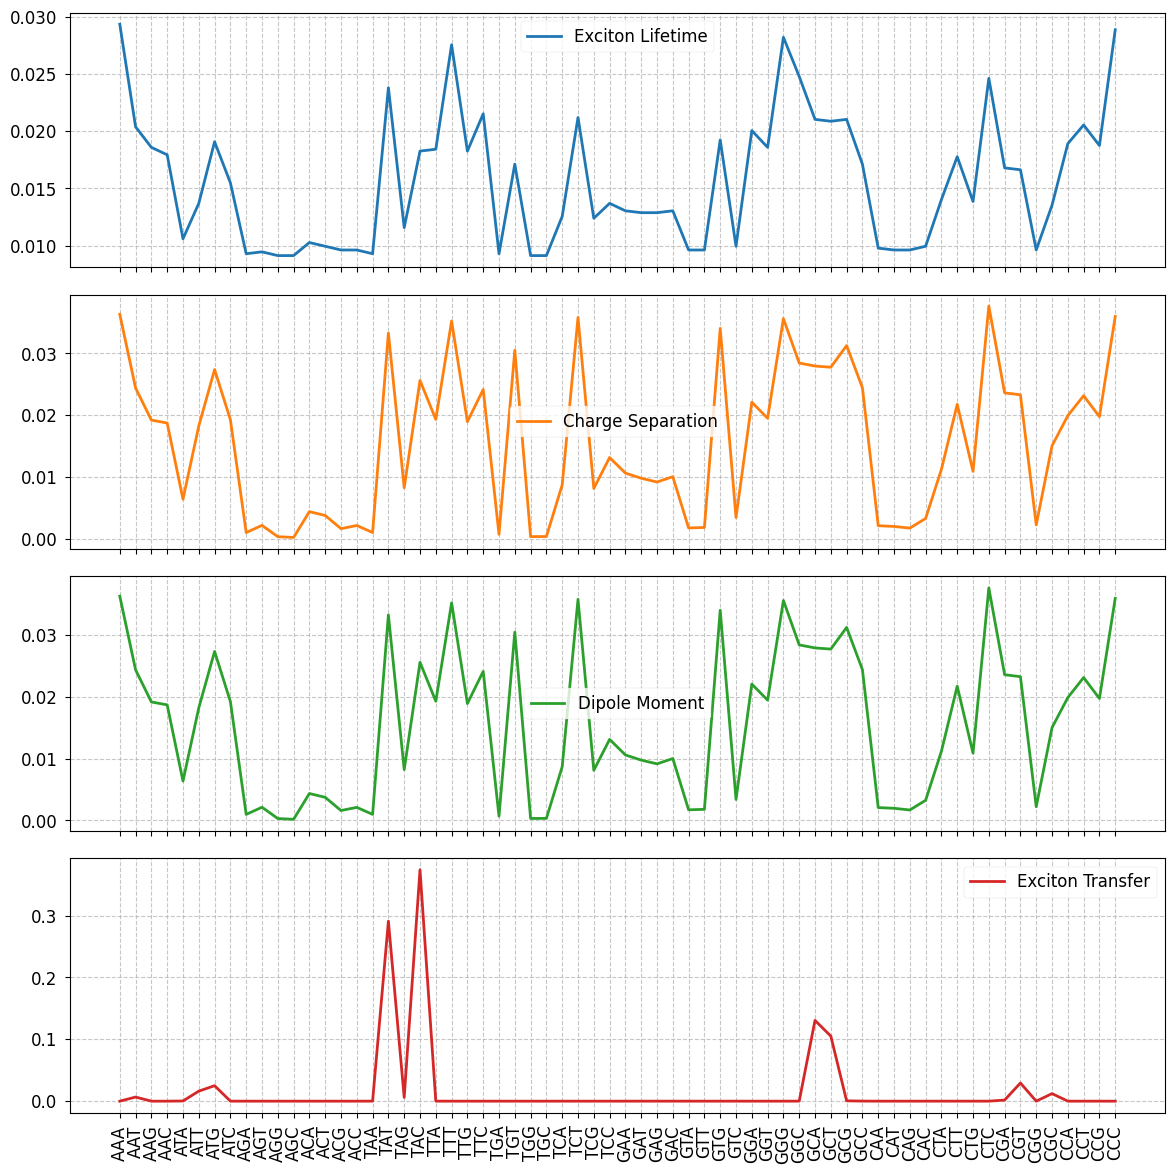

In [64]:
import seaborn as sns

def normalize_dict_values(data):
    total = sum(data.values())
    return {key: value / total for key, value in data.items()}

dicts = [normalize_dict_values(dictionary) for dictionary in [lifetime_dict, dipole_dict, dipole_moment_dict, exciton_transfer_lower_dict]]
labels = ['Exciton Lifetime', 'Charge Separation', 'Dipole Moment', 'Exciton Transfer']
colors = sns.color_palette()[:4]

fig, ax = plt.subplots(4, 1, figsize=(12,12), sharex=True)
for i in range(4):
    dictionary = dicts[i]
    ax[i].plot(range(64), dictionary.values(), label=labels[i], color=colors[i])
    ax[i].legend()
    
dna_seqs = list(lifetime_dict.keys())
ax[-1].set_xticks(range(64), labels=dna_seqs, rotation=90)

if save:
    save_figure(fig, 'trimer_analysis', SAVE_DIR, extension='pdf')
plt.show()

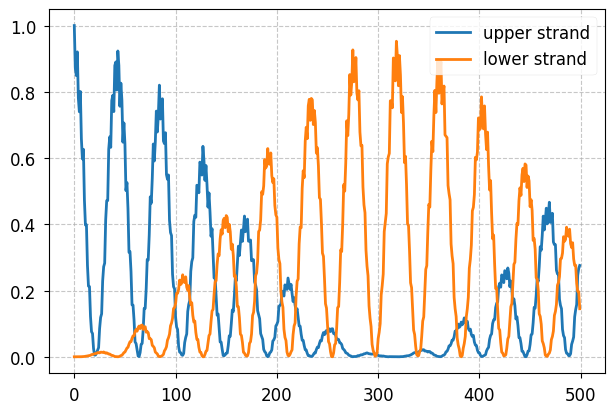

In [59]:
# The analysis above shows there are some intersting triplet sequences (TAT, TAC, GCA, GCT). Let's have a closer look.
from qDNA import calc_exciton_transfer

upper_strand ='GCT'
tb_model_name = 'ELM'
kwargs = dict(particles=['exciton'])

pop_upper_strand, pop_lower_strand = calc_exciton_transfer(upper_strand, tb_model_name, average=False, **kwargs)

fig, ax = plt.subplots()
ax.plot(pop_upper_strand['exciton'], label='upper strand')
ax.plot(pop_lower_strand['exciton'], label='lower strand')
ax.legend()

if save:
    save_figure(fig, 'special_trimers', SAVE_DIR, extension='pdf')
plt.show()

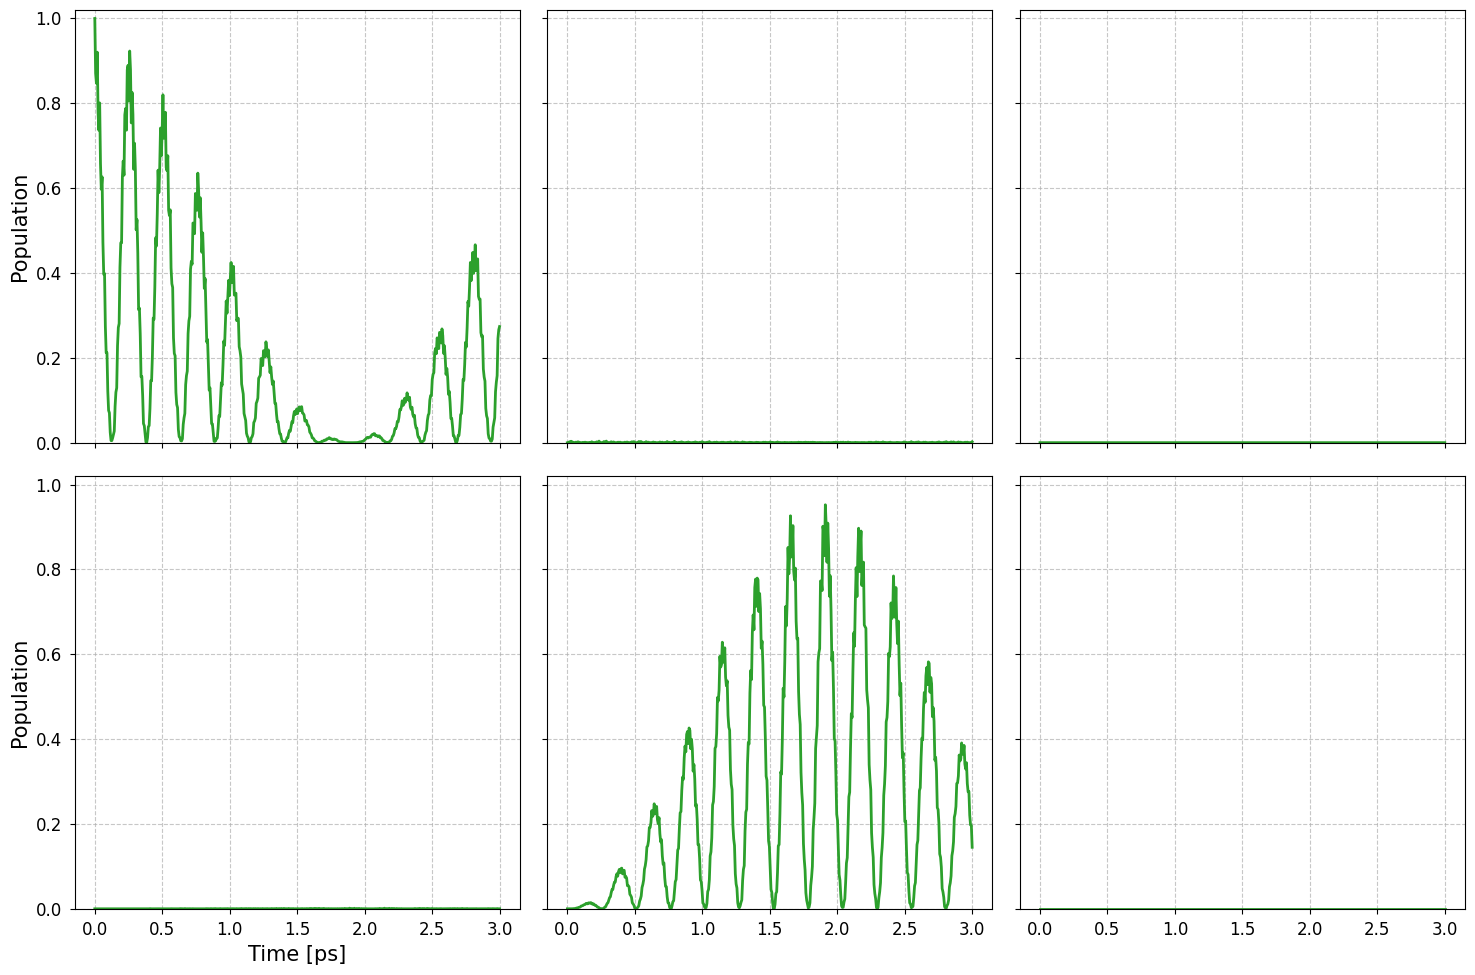

In [62]:
# we observe how the exciton gets transferred to the lower strand

from qDNA import get_me_solver, plot_pops

me_solver = get_me_solver(upper_strand, tb_model_name, **kwargs)

fig, ax = plot_pops(me_solver)